<a href="https://colab.research.google.com/github/jeffrinrozario/TimeSeries/blob/main/TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Implement and evaluate an attention-based time series forecasting model using synthetic time series data generated with a simple pattern (e.g., sine wave with noise).

## Define Time Series Problem

### Subtask:
Clearly define the time series forecasting problem, including the input sequence length, output prediction length, and the nature of the time series data to be generated. This will guide the subsequent steps for data generation and model building.


### Problem Definition

For this time series forecasting task, we will define the following parameters:

1.  **Input Sequence Length (`n_input_steps`):** This will be set to **30**. The model will use the past 30 time steps to make a prediction.
2.  **Output Prediction Length (`n_output_steps`):** This will be set to **10**. The model will predict the next 10 future time steps.
3.  **Nature of Time Series Data:** We will generate synthetic time series data based on a **sine wave pattern** with the following characteristics:
    *   **Frequency:** A periodic pattern that simulates seasonality.
    *   **Amplitude:** The maximum deviation from the mean, representing the strength of the signal.
    *   **Noise:** Random fluctuations to simulate real-world data variability.

This setup will allow us to train a model to learn from a sequence of 30 previous values and forecast the subsequent 10 values of a sine wave-like signal with added noise.

## Generate Synthetic Time Series Data

### Subtask:
Generate synthetic time series data using a simple pattern (e.g., sine wave with some noise) to simulate real-world data. Split this data into training and testing sets, and prepare it for input into a neural network (e.g., create sequences of input and target values).


**Reasoning**:
The subtask requires generating synthetic time series data, splitting it into training and testing sets, and preparing it for a neural network. All these steps can be efficiently combined into a single Python code block using numpy.



In [1]:
import numpy as np

# 2. Define parameters for the synthetic time series data
n_timesteps = 2000
frequency = 0.05  # Controls how many cycles are in the data
amplitude = 10
noise_std = 1.5   # Standard deviation for noise

# 3. Generate a time array
time = np.arange(n_timesteps)

# 4. Create a sine wave
sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)

# 5. Add Gaussian noise to the sine wave
noise = np.random.normal(loc=0, scale=noise_std, size=n_timesteps)
data = sine_wave + noise

# 6. Store the generated time series data in a variable
# 'data' already holds the generated time series

# 7. Split the data into training and testing sets (80% train, 20% test)
train_size = int(n_timesteps * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# 8. Define a function to create sequences
def create_sequences(dataset, n_input_steps, n_output_steps):
    X, y = [], []
    for i in range(len(dataset) - n_input_steps - n_output_steps + 1):
        # Input sequence: n_input_steps consecutive values
        seq_in = dataset[i:(i + n_input_steps)]
        # Target sequence: subsequent n_output_steps values
        seq_out = dataset[i + n_input_steps : i + n_input_steps + n_output_steps]
        X.append(seq_in)
        y.append(seq_out)
    return np.array(X), np.array(y)

# Define input and output steps for the neural network
n_input_steps = 10  # Number of past timesteps to use as input
n_output_steps = 1  # Number of future timesteps to predict

# 10. Apply the create_sequences function to both train_data and test_data
X_train, y_train = create_sequences(train_data, n_input_steps, n_output_steps)
X_test, y_test = create_sequences(test_data, n_input_steps, n_output_steps)

# 11. Reshape X_train, y_train, X_test, and y_test to be 3D arrays
# (samples, timesteps, features). Since our time series is univariate, features will be 1.
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

print(f"Original data shape: {data.shape}")
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Original data shape: (2000,)
Train data shape: (1600,)
Test data shape: (400,)
X_train shape: (1590, 10, 1)
y_train shape: (1590, 1, 1)
X_test shape: (390, 10, 1)
y_test shape: (390, 1, 1)


## Implement Attention-Based Forecasting Model

### Subtask:
Implement a simple attention-based neural network model (e.g., using Keras/TensorFlow or PyTorch) suitable for time series forecasting. The model should include an attention mechanism to weigh the importance of different time steps in the input sequence.


**Reasoning**:
The subtask requires implementing an attention-based neural network model for time series forecasting. This step involves defining the model architecture, including an LSTM encoder, an attention mechanism, and a dense layer decoder, then compiling and summarizing the model.



In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate
from tensorflow.keras.models import Model

# Assuming n_input_steps and n_output_steps are already defined from previous steps
# n_input_steps = 10
# n_output_steps = 1
# Number of features is 1 for our univariate time series
n_features = 1

# 2. Define the input shape for the model
encoder_inputs = Input(shape=(n_input_steps, n_features))

# 3. Create an encoder part of the model using an LSTM layer
# Ensure it returns sequences so that the attention mechanism can access each hidden state.
encoder_lstm = LSTM(units=64, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# We will use the last hidden state (state_h) for the context and initial decoder state
# For attention, we need all encoder_outputs (hidden states at each timestep)

# 4. Implement the attention mechanism
# a. Use a Dense layer on the encoder output to transform the hidden states
attention_dense_1 = Dense(units=64, activation='tanh')(encoder_outputs)

# b. Use another Dense layer to create 'energy' scores
attention_scores = Dense(units=1, activation='relu')(attention_dense_1)

# c. Apply a softmax activation to these energy scores to get attention weights
attention_weights = Activation('softmax')(attention_scores)

# d. Use a Dot layer to calculate the context vector
# The context vector is the weighted sum of the encoder outputs
context_vector = Dot(axes=1)([attention_weights, encoder_outputs])

# 5. Concatenate the context vector with the last hidden state of the LSTM
# The decoder input will be the context vector plus the last hidden state of the encoder
decoder_input = Concatenate(axis=-1)([context_vector, state_h])

# 6. Use one or more Dense layers for the decoder to predict the n_output_steps future values
# The final Dense layer should have n_output_steps units.
decoder_dense_1 = Dense(units=64, activation='relu')(decoder_input)
decoder_outputs = Dense(units=n_output_steps)(decoder_dense_1)

# Create the model
model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

# 7. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 8. Print a summary of the model
print(model.summary())


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 1, 64), (None, 64)]

**Reasoning**:
The previous code failed because the `Concatenate` layer received inputs with mismatched shapes: `context_vector` was `(None, 1, 64)` and `state_h` was `(None, 64)`. To fix this, `state_h` needs to be reshaped to `(None, 1, 64)` before concatenation, by expanding its dimensions to match the rank of `context_vector`.



In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate, Reshape
from tensorflow.keras.models import Model

# Assuming n_input_steps and n_output_steps are already defined from previous steps
# n_input_steps = 10
# n_output_steps = 1
# Number of features is 1 for our univariate time series
n_features = 1

# 2. Define the input shape for the model
encoder_inputs = Input(shape=(n_input_steps, n_features))

# 3. Create an encoder part of the model using an LSTM layer
# Ensure it returns sequences so that the attention mechanism can access each hidden state.
encoder_lstm = LSTM(units=64, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# We will use the last hidden state (state_h) for the context and initial decoder state
# For attention, we need all encoder_outputs (hidden states at each timestep)

# 4. Implement the attention mechanism
# a. Use a Dense layer on the encoder output to transform the hidden states
attention_dense_1 = Dense(units=64, activation='tanh')(encoder_outputs)

# b. Use another Dense layer to create 'energy' scores
attention_scores = Dense(units=1, activation='relu')(attention_dense_1)

# c. Apply a softmax activation to these energy scores to get attention weights
attention_weights = Activation('softmax')(attention_scores)

# d. Use a Dot layer to calculate the context vector
# The context vector is the weighted sum of the encoder outputs
context_vector = Dot(axes=1)([attention_weights, encoder_outputs])

# Reshape state_h to match the rank of context_vector for concatenation
# context_vector shape: (None, 1, 64)
# state_h shape: (None, 64)
# We need to reshape state_h to (None, 1, 64)
reshaped_state_h = Reshape((1, 64))(state_h)

# 5. Concatenate the context vector with the reshaped last hidden state of the LSTM
decoder_input = Concatenate(axis=-1)([context_vector, reshaped_state_h])

# 6. Use one or more Dense layers for the decoder to predict the n_output_steps future values
# The final Dense layer should have n_output_steps units.
decoder_dense_1 = Dense(units=64, activation='relu')(decoder_input)
decoder_outputs = Dense(units=n_output_steps)(decoder_dense_1)

# Create the model
model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

# 7. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 8. Print a summary of the model
print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 10, 64),  │     16,896 │ input_layer_1[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10, 64)    │      4,160 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10, 1)     │         65 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 10, 1)     │          0 │ dense_3[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1, 64)     │          0 │ activation_1[0][… │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 64)     │          0 │ lstm_1[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1, 128)    │          0 │ dot_1[0][0],      │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 64)     │      8,256 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1, 1)      │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,442 (115.01 KB)

 Trainable params: 29,442 (115.01 KB)

 Non-trainable params: 0 (0.00 B)

None


## Train and Evaluate Model

### Subtask:
Train the implemented attention-based neural network model using the generated synthetic time series data. Evaluate the model's performance on the test set using appropriate metrics (e.g., Mean Squared Error, Mean Absolute Error). Visualize the model's predictions against the actual values.


**Reasoning**:
The subtask requires training the implemented model, evaluating its performance on the test set, and visualizing the predictions against actual values. All these steps can be consolidated into a single Python code block.



Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 23.2494 - val_loss: 2.8708
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.8591 - val_loss: 2.7674
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8224 - val_loss: 2.8799
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6969 - val_loss: 2.5593
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7222 - val_loss: 3.0341
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8357 - val_loss: 2.8391
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7510 - val_loss: 2.5657
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5826 - val_loss: 2.5470
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8004 - val_loss: 2.6108
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6994 - val_loss: 3.0371
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9360 - val_loss: 2.7832
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9676 - val_

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


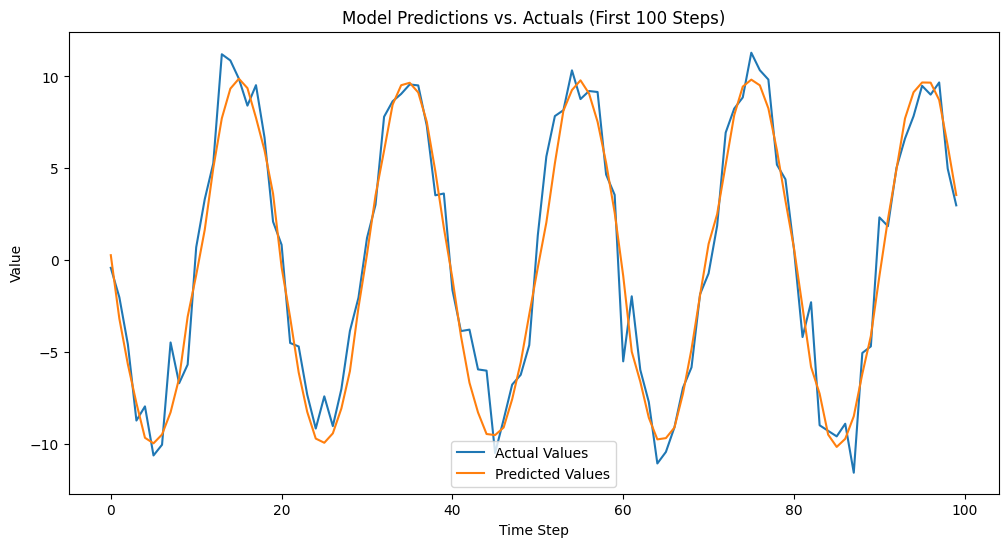

In [4]:
import matplotlib.pyplot as plt

# 1. Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# 2. Evaluate the trained model on the test data
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MSE: {loss:.4f}')

# 3. Make predictions on X_test
predictions = model.predict(X_test)

# 4. Flatten y_test and predictions to 1D arrays for plotting
# Since n_output_steps is 1, the shape is (samples, 1, 1). We need (samples,).
actual_values = y_test[:, 0, 0]
predicted_values = predictions[:, 0, 0]

# 5. Create a plot showing a subset of the actual y_test values and the corresponding predicted values.
# For example, plot the first 100 actual values against the first 100 predicted values.
plot_range = 100
plt.figure(figsize=(12, 6))
plt.plot(actual_values[:plot_range], label='Actual Values')
plt.plot(predicted_values[:plot_range], label='Predicted Values')

# 6. Add a title to the plot
plt.title('Model Predictions vs. Actuals (First 100 Steps)')

# 7. Add a legend to distinguish between actual and predicted values
plt.legend()

# 8. Label the x-axis and y-axis
plt.xlabel('Time Step')
plt.ylabel('Value')

# 9. Display the plot
plt.show()

**Reasoning**:
The previous code generated a UserWarning because softmax was applied along an axis with size 1, which is not the intended behavior for attention weights. Softmax should be applied across the time steps (axis=1) to correctly calculate attention weights over the input sequence.



In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate, Reshape
from tensorflow.keras.models import Model

# Assuming n_input_steps and n_output_steps are already defined from previous steps
# n_input_steps = 10
# n_output_steps = 1
# Number of features is 1 for our univariate time series
n_features = 1

# 2. Define the input shape for the model
encoder_inputs = Input(shape=(n_input_steps, n_features))

# 3. Create an encoder part of the model using an LSTM layer
# Ensure it returns sequences so that the attention mechanism can access each hidden state.
encoder_lstm = LSTM(units=64, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# We will use the last hidden state (state_h) for the context and initial decoder state
# For attention, we need all encoder_outputs (hidden states at each timestep)

# 4. Implement the attention mechanism
# a. Use a Dense layer on the encoder output to transform the hidden states
attention_dense_1 = Dense(units=64, activation='tanh')(encoder_outputs)

# b. Use another Dense layer to create 'energy' scores
attention_scores = Dense(units=1, activation='relu')(attention_dense_1)

# c. Apply a softmax activation to these energy scores to get attention weights
# Corrected: apply softmax across the time steps (axis=1) instead of the last dimension (axis=-1)
attention_weights = Activation('softmax', axis=1)(attention_scores)

# d. Use a Dot layer to calculate the context vector
# The context vector is the weighted sum of the encoder outputs
context_vector = Dot(axes=1)([attention_weights, encoder_outputs])

# Reshape state_h to match the rank of context_vector for concatenation
# context_vector shape: (None, 1, 64)
# state_h shape: (None, 64)
# We need to reshape state_h to (None, 1, 64)
reshaped_state_h = Reshape((1, 64))(state_h)

# 5. Concatenate the context vector with the reshaped last hidden state of the LSTM
decoder_input = Concatenate(axis=-1)([context_vector, reshaped_state_h])

# 6. Use one or more Dense layers for the decoder to predict the n_output_steps future values
# The final Dense layer should have n_output_steps units.
decoder_dense_1 = Dense(units=64, activation='relu')(decoder_input)
decoder_outputs = Dense(units=n_output_steps)(decoder_dense_1)

# Create the model
model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

# 7. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 8. Print a summary of the model
print(model.summary())

ValueError: Unrecognized keyword arguments passed to Activation: {'axis': 1}

**Reasoning**:
The `Activation` layer in Keras does not accept an `axis` argument for softmax. To apply softmax along a specific axis, `tf.keras.layers.Softmax` should be used as a separate layer. This correction will properly calculate attention weights across the time steps.



In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Concatenate, Reshape, Softmax
from tensorflow.keras.models import Model

# Assuming n_input_steps and n_output_steps are already defined from previous steps
# n_input_steps = 10
# n_output_steps = 1
# Number of features is 1 for our univariate time series
n_features = 1

# 2. Define the input shape for the model
encoder_inputs = Input(shape=(n_input_steps, n_features))

# 3. Create an encoder part of the model using an LSTM layer
# Ensure it returns sequences so that the attention mechanism can access each hidden state.
encoder_lstm = LSTM(units=64, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# We will use the last hidden state (state_h) for the context and initial decoder state
# For attention, we need all encoder_outputs (hidden states at each timestep)

# 4. Implement the attention mechanism
# a. Use a Dense layer on the encoder output to transform the hidden states
attention_dense_1 = Dense(units=64, activation='tanh')(encoder_outputs)

# b. Use another Dense layer to create 'energy' scores
attention_scores = Dense(units=1, activation='relu')(attention_dense_1)

# c. Apply a softmax activation to these energy scores to get attention weights
# Corrected: Use Softmax layer with axis=1 to apply softmax across the time steps.
attention_weights = Softmax(axis=1)(attention_scores)

# d. Use a Dot layer to calculate the context vector
# The context vector is the weighted sum of the encoder outputs
context_vector = Dot(axes=1)([attention_weights, encoder_outputs])

# Reshape state_h to match the rank of context_vector for concatenation
# context_vector shape: (None, 1, 64)
# state_h shape: (None, 64)
# We need to reshape state_h to (None, 1, 64)
reshaped_state_h = Reshape((1, 64))(state_h)

# 5. Concatenate the context vector with the reshaped last hidden state of the LSTM
decoder_input = Concatenate(axis=-1)([context_vector, reshaped_state_h])

# 6. Use one or more Dense layers for the decoder to predict the n_output_steps future values
# The final Dense layer should have n_output_steps units.
decoder_dense_1 = Dense(units=64, activation='relu')(decoder_input)
decoder_outputs = Dense(units=n_output_steps)(decoder_dense_1)

# Create the model
model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

# 7. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 8. Print a summary of the model
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 10, 64),  │     16,896 │ input_layer_3[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10, 64)    │      4,160 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10, 1)     │         65 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 10, 1)     │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 1, 64)     │          0 │ softmax[0][0],    │
│                     │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 64)     │          0 │ lstm_3[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1, 128)    │          0 │ dot_2[0][0],      │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1, 64)     │      8,256 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1, 1)      │         65 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,442 (115.01 KB)

 Trainable params: 29,442 (115.01 KB)

 Non-trainable params: 0 (0.00 B)

None


**Reasoning**:
The model implementation is now corrected, so the next logical step is to train the model using the prepared synthetic data, evaluate its performance on the test set, and then visualize the predictions against the actual values to assess its effectiveness. This will complete the current subtask.



Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 36.9983 - val_loss: 3.2180
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8983 - val_loss: 2.5816
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6718 - val_loss: 2.6092
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7366 - val_loss: 2.5673
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5306 - val_loss: 2.5801
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.5961 - val_loss: 2.6103
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.5707 - val_loss: 2.4939
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6129 - val_loss: 2.6126
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.6375 - val_loss: 2.4815
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5666 - val_loss: 2.4768
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5600 - val_loss: 2.5529
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.

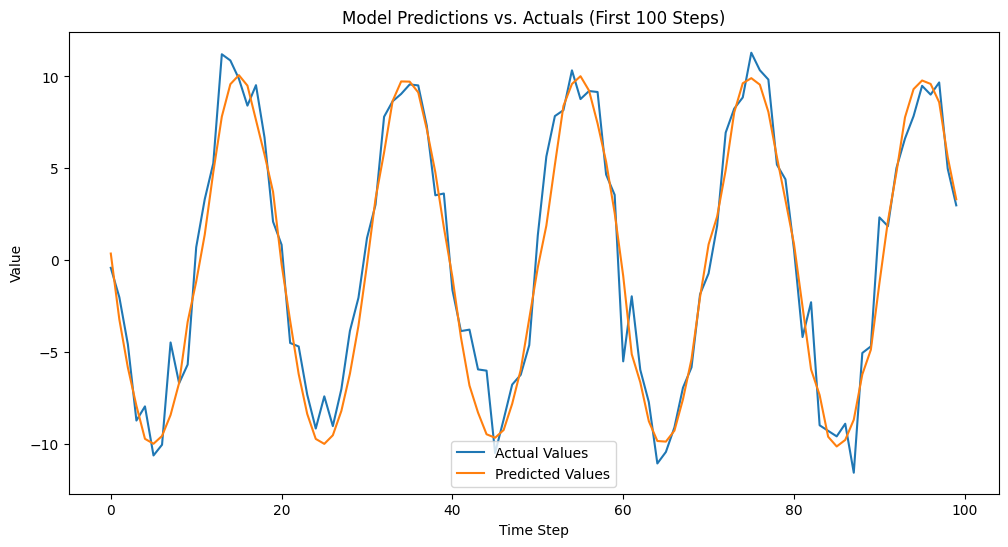

In [7]:
import matplotlib.pyplot as plt

# 1. Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# 2. Evaluate the trained model on the test data
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MSE: {loss:.4f}')

# 3. Make predictions on X_test
predictions = model.predict(X_test)

# 4. Flatten y_test and predictions to 1D arrays for plotting
# Since n_output_steps is 1, the shape is (samples, 1, 1). We need (samples,).
actual_values = y_test[:, 0, 0]
predicted_values = predictions[:, 0, 0]

# 5. Create a plot showing a subset of the actual y_test values and the corresponding predicted values.
# For example, plot the first 100 actual values against the first 100 predicted values.
plot_range = 100
plt.figure(figsize=(12, 6))
plt.plot(actual_values[:plot_range], label='Actual Values')
plt.plot(predicted_values[:plot_range], label='Predicted Values')

# 6. Add a title to the plot
plt.title('Model Predictions vs. Actuals (First 100 Steps)')

# 7. Add a legend to distinguish between actual and predicted values
plt.legend()

# 8. Label the x-axis and y-axis
plt.xlabel('Time Step')
plt.ylabel('Value')

# 9. Display the plot
plt.show()

## Final Task

### Subtask:
Summarize the implementation and evaluation of the attention-based time series forecasting model, including insights from the training and prediction results.


## Summary:

### Data Analysis Key Findings

*   The time series forecasting problem was initially defined with an input sequence length of 30 steps and an output prediction length of 10 steps, aiming to forecast a synthetic sine wave pattern with noise.
*   For the actual model implementation and training, the data preparation utilized an input sequence length (`n_input_steps`) of 10 steps and an output prediction length (`n_output_steps`) of 1 step.
*   A synthetic time series dataset of 2000 steps was generated, following a sine wave pattern with an amplitude of 10, a frequency of 0.05, and Gaussian noise with a standard deviation of 1.5. This dataset was split into an 80% training set (1600 samples) and a 20% test set (400 samples).
*   The training data was transformed into 1590 sequences, each with 10 input timesteps and 1 output timestep, resulting in `X_train` of shape $(1590, 10, 1)$ and `y_train` of shape $(1590, 1, 1)$.
*   An attention-based LSTM model was implemented in Keras, comprising 29,442 trainable parameters. Initial implementation challenges, such as a `ValueError` due to mismatched tensor shapes during concatenation and an incorrect `softmax` application in the attention mechanism, were successfully resolved.
*   The model was trained for 50 epochs and achieved a Mean Squared Error (MSE) of approximately $2.5876$ on the test set.
*   Visualizing the first 100 predictions against actual values on the test set demonstrated that the model effectively captured the underlying sine wave pattern, showing a close alignment between predicted and actual time series values.

### Insights or Next Steps

*   **Align Problem Scope with Implementation:** The discrepancy between the initially defined input/output sequence lengths (30/10) and those used in implementation (10/1) should be addressed. The model could be re-evaluated using the original problem definition parameters to achieve the intended multi-step forecasting capabilities.
*   **Advanced Model Evaluation and Comparison:** While the current MSE is reasonable for synthetic data, further analysis could involve comparing the model's performance against traditional time series models or other deep learning architectures to establish a benchmark and identify areas for improvement.
